# Transforms and Resampling <a href="https://mybinder.org/v2/gh/InsightSoftwareConsortium/SimpleITK-Notebooks/master?filepath=Python%2F21_Transforms_and_Resampling.ipynb"><img style="float: right;" src="https://mybinder.org/badge_logo.svg"></a>

This notebook explains how to apply transforms to images, and how to perform image resampling.

In [1]:
import SimpleITK as sitk
import numpy as np


import gui
from matplotlib import pyplot as plt
from ipywidgets import interact, fixed

# Utility method that either downloads data from the Girder repository or
# if already downloaded returns the file name for reading from disk (cached data).
%run update_path_to_download_script
from downloaddata import fetch_data as fdata
%matplotlib inline

In [2]:
from IPython.display import display, HTML
display("text/html", "<style>.container { width:100% !important; }</style>")
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

'text/html'

'<style>.container { width:100% !important; }</style>'

## Creating and Manipulating Transforms

A number of different spatial transforms are available in SimpleITK.

## The simplest is the Identity Transform.  This transform simply returns input points unaltered.

In [3]:
dimension = 2

print("*Identity Transform*")
identity = sitk.Transform(dimension, sitk.sitkIdentity)
print("Dimension: " + str(identity.GetDimension()))

# Points are always defined in physical space
point = (1.0, 1.0)


def transform_point(transform, point):
    transformed_point = transform.TransformPoint(point)
    print("Point " + str(point) + " transformed is " + str(transformed_point))


transform_point(identity, point)

*Identity Transform*
Dimension: 2
Point (1.0, 1.0) transformed is (1.0, 1.0)


## Transform are defined by two sets of parameters, the *Parameters* and *FixedParameters*.  

*FixedParameters* are not changed during the optimization process when performing registration.  For the TranslationTransform, the Parameters are the values of the translation Offset.

### TranslationTransform

In [4]:
print("*Translation Transform*")
translation = sitk.TranslationTransform(dimension)

print("Parameters: " + str(translation.GetParameters()))
print("Offset:     " + str(translation.GetOffset()))
print("FixedParameters: " + str(translation.GetFixedParameters()))
transform_point(translation, point)

print("\nAfter Translation Transform")
translation.SetParameters((1.0, 10.0))
print("Parameters: " + str(translation.GetParameters()))
transform_point(translation, point)

*Translation Transform*
Parameters: (0.0, 0.0)
Offset:     (0.0, 0.0)
FixedParameters: ()
Point (1.0, 1.0) transformed is (1.0, 1.0)

After Translation Transform
Parameters: (1.0, 10.0)
Point (1.0, 1.0) transformed is (2.0, 11.0)


The affine transform is capable of representing translations, rotations, shearing, and scaling.

### AffineTransform

In [5]:
print("*Affine Transform*")
affine = sitk.AffineTransform(dimension)

print("Parameters: " + str(affine.GetParameters()))
print("FixedParameters: " + str(affine.GetFixedParameters()))
transform_point(affine, point)

print("\nAfter Affine Transform")
affine.SetTranslation((3.1, 4.4))
print("Parameters: " + str(affine.GetParameters()))
transform_point(affine, point)

*Affine Transform*
Parameters: (1.0, 0.0, 0.0, 1.0, 0.0, 0.0)
FixedParameters: (0.0, 0.0)
Point (1.0, 1.0) transformed is (1.0, 1.0)

After Affine Transform
Parameters: (1.0, 0.0, 0.0, 1.0, 3.1, 4.4)
Point (1.0, 1.0) transformed is (4.1, 5.4)


A number of other transforms exist to represent non-affine deformations, well-behaved rotation in 3D, etc. See 22_Transforms.ipynb the [Transforms](22_Transforms.ipynb) tutorial for more information.

## Applying Transforms to Images

Create a function to display the images that is aware of image spacing.

In [6]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()

    ysize = nda.shape[0]
    xsize = nda.shape[1]

    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(title, figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2 * margin, 1 - 2 * margin])

    extent = (0, xsize * spacing[1], 0, ysize * spacing[0])

    t = ax.imshow(
        nda, extent=extent, interpolation="hamming", cmap="gray", origin="lower"
    )

    if title:
        plt.title(title)

Create a grid image.

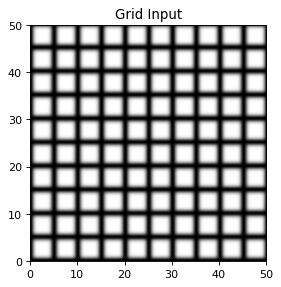

In [7]:
grid = sitk.GridSource(
    outputPixelType=sitk.sitkUInt16,
    size=(250, 250),
    sigma=(0.5, 0.5),
    gridSpacing=(5.0, 5.0),
    gridOffset=(0.0, 0.0),
    spacing=(0.2, 0.2),
)
myshow(grid, "Grid Input")

### To apply the transform, a resampling operation is required.

Point (1.0, 1.0) transformed is (2.0, 11.1)


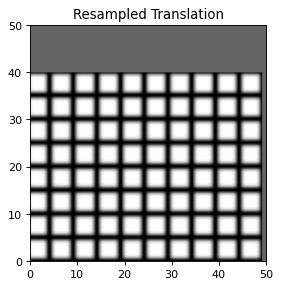

In [8]:
def transform_point(transform, point):
    transformed_point = transform.TransformPoint(point)
    print("Point " + str(point) + " transformed is " + str(transformed_point))
    
def resample(image, transform):
    # Output image Origin, Spacing, Size, Direction are taken from the reference image in this call to Resample
    reference_image = image
    interpolator = sitk.sitkCosineWindowedSinc
    default_value = 100.0
    return sitk.Resample(image, reference_image, transform, interpolator, default_value)


translation.SetOffset((1.0, 10.1))
transform_point(translation, point)
resampled = resample(grid, translation)
myshow(resampled, "Resampled Translation")

What happened?  The translation is positive in both directions.  Why does the output image move down and to the left?  

### It important to keep in mind that a transform in a resampling operation defines *the transform from the output space to the input space*.

## Inverse Transform

In [9]:
-1 * np.array(translation.GetParameters())

array([ -1. , -10.1])

Point (1.0, 1.0) transformed is (0.0, -9.1)


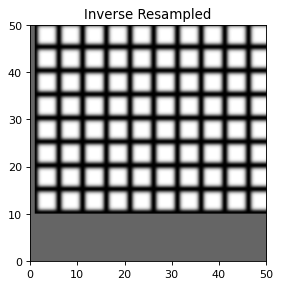

In [10]:
translation.SetOffset(-1 * np.array(translation.GetParameters()))
transform_point(translation, point)
resampled = resample(grid, translation)
myshow(resampled, "Inverse Resampled")

### An affine (line preserving) transformation, can perform translation:

In [11]:
def affine_translate(transform, x_translation=3.1, y_translation=4.6):
    new_transform = sitk.AffineTransform(transform)
    new_transform.SetTranslation((x_translation, y_translation))
    resampled = resample(grid, new_transform)
    myshow(resampled, "Translated")
    return new_transform


affine = sitk.AffineTransform(dimension)

interact(
    affine_translate,
    transform=fixed(affine),
    x_translation=(-5.0, 5.0),
    y_translation=(-5.0, 5.0),
);

interactive(children=(FloatSlider(value=3.1, description='x_translation', max=5.0, min=-5.0), FloatSlider(valu…

or scaling:

In [12]:
def affine_scale(transform, x_scale=3.0, y_scale=0.7):
    new_transform = sitk.AffineTransform(transform)
    matrix = np.array(transform.GetMatrix()).reshape((dimension, dimension))
    matrix[0, 0] = x_scale
    matrix[1, 1] = y_scale
    new_transform.SetMatrix(matrix.ravel())
    resampled = resample(grid, new_transform)
    myshow(resampled, "Scaled")
    print(matrix)
    return new_transform


affine = sitk.AffineTransform(dimension)

interact(affine_scale, transform=fixed(affine), x_scale=(0.2, 5.0), y_scale=(0.2, 5.0));

interactive(children=(FloatSlider(value=3.0, description='x_scale', max=5.0, min=0.2), FloatSlider(value=0.7, …

or rotation:

In [13]:
def affine_rotate(transform, degrees=15.0):
    parameters = np.array(transform.GetParameters())
    new_transform = sitk.AffineTransform(transform)
    matrix = np.array(transform.GetMatrix()).reshape((dimension, dimension))
    radians = -np.pi * degrees / 180.0
    rotation = np.array(
        [[np.cos(radians), -np.sin(radians)], [np.sin(radians), np.cos(radians)]]
    )
    new_matrix = np.dot(rotation, matrix)
    new_transform.SetMatrix(new_matrix.ravel())
    resampled = resample(grid, new_transform)
    print(new_matrix)
    myshow(resampled, "Rotated")
    return new_transform


affine = sitk.AffineTransform(dimension)

interact(affine_rotate, transform=fixed(affine), degrees=(-90.0, 90.0)); #interact is ipywidget

interactive(children=(FloatSlider(value=15.0, description='degrees', max=90.0, min=-90.0), Output()), _dom_cla…

or shearing:

In [14]:
def affine_shear(transform, x_shear=0.3, y_shear=0.1):
    new_transform = sitk.AffineTransform(transform)
    matrix = np.array(transform.GetMatrix()).reshape((dimension, dimension))
    matrix[0, 1] = -x_shear
    matrix[1, 0] = -y_shear
    new_transform.SetMatrix(matrix.ravel())
    resampled = resample(grid, new_transform)
    myshow(resampled, "Sheared")
    print(matrix)
    return new_transform


affine = sitk.AffineTransform(dimension)

interact(affine_shear, transform=fixed(affine), x_shear=(0.1, 2.0), y_shear=(0.1, 2.0));

interactive(children=(FloatSlider(value=0.3, description='x_shear', max=2.0, min=0.1), FloatSlider(value=0.1, …

## Composite Transform

It is possible to compose multiple transform together into a single transform object.  

With a composite transform, multiple resampling operations are prevented, so interpolation errors are not accumulated.  

For example, an affine transformation that consists of a translation and rotation,

[[ 0.93969262  0.34202014]
 [-0.34202014  0.93969262]]


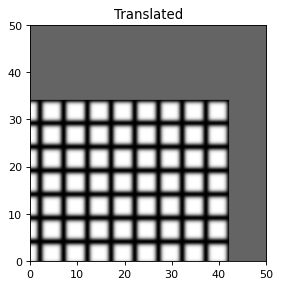

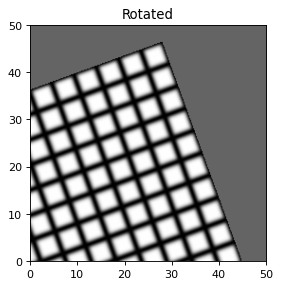

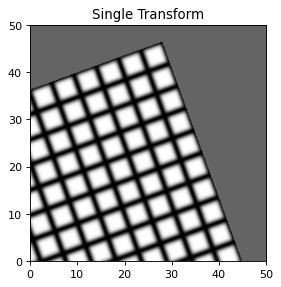

In [15]:
translate = (8.0, 16.0)
rotate = 20.0

affine = sitk.AffineTransform(dimension)
affine = affine_translate(affine, translate[0], translate[1])
affine = affine_rotate(affine, rotate)

resampled = resample(grid, affine)
myshow(resampled, "Single Transform")

can also be represented with two Transform objects applied in sequence with a Composite Transform,

[[ 0.93969262  0.34202014]
 [-0.34202014  0.93969262]]


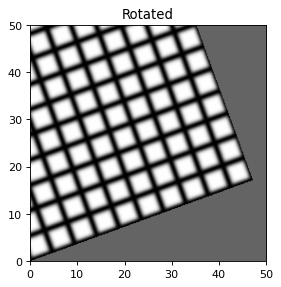

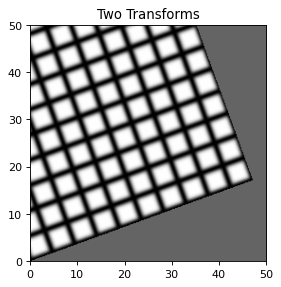

In [16]:
composite = sitk.CompositeTransform(dimension)
translation = sitk.TranslationTransform(dimension)
translation.SetOffset(-1 * np.array(translate))
composite.AddTransform(translation)
affine = sitk.AffineTransform(dimension)
affine = affine_rotate(affine, rotate)

composite.AddTransform(translation)
composite = sitk.CompositeTransform(dimension)
composite.AddTransform(affine)

resampled = resample(grid, composite)
myshow(resampled, "Two Transforms")

*Beware*, tranforms are non-commutative -- order matters!

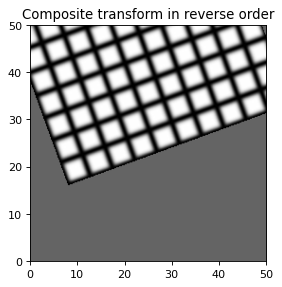

In [17]:
composite = sitk.CompositeTransform(dimension)
composite.AddTransform(affine)
composite.AddTransform(translation)

resampled = resample(grid, composite)
myshow(resampled, "Composite transform in reverse order")

## Resampling

<img src="resampling.svg"/><br><br>

### Resampling as the verb implies is the action of sampling an image, which itself is a sampling of an original continuous signal.

Generally speaking, resampling in SimpleITK involves four components:
1. *Image* - the image we resample, given in coordinate system $m$.
2. *Resampling grid* - a regular grid of points given in coordinate system $f$ which will be mapped to coordinate system $m$.
2. *Transformation* $T_f^m$ - maps points from coordinate system $f$ to coordinate system $m$, $^mp = T_f^m(^fp)$.
3. *Interpolator* - method for obtaining the intensity values at arbitrary points in coordinate system $m$ from the values of the points defined by the Image.


While SimpleITK provides a large number of interpolation methods, the two most commonly used are ```sitkLinear``` and ```sitkNearestNeighbor```. The former is used for most interpolation tasks, a compromise between accuracy and computational efficiency. The later is used to interpolate labeled images representing a segmentation, it is the only interpolation approach which will not introduce new labels into the result.

SimpleITK's procedural API provides three methods for performing resampling, with the difference being the way you specify the resampling grid:

-- ```Resample(const Image &image1, Transform transform, InterpolatorEnum interpolator, double defaultPixelValue, PixelIDValueEnum outputPixelType)```

-- ```Resample(const Image &image1, const Image &referenceImage, Transform transform, InterpolatorEnum interpolator, double defaultPixelValue, PixelIDValueEnum outputPixelType)```

-- ```Resample(const Image &image1, std::vector< uint32_t > size, Transform transform, InterpolatorEnum interpolator, std::vector< double > outputOrigin, std::vector< double > outputSpacing, std::vector< double > outputDirection, double defaultPixelValue, PixelIDValueEnum outputPixelType)```

In [28]:
def resample_display(image, euler2d_transform, tx, ty, theta):
    euler2d_transform.SetTranslation((tx, ty))
    euler2d_transform.SetAngle(theta)

    resampled_image = sitk.Resample(image, euler2d_transform)
    plt.imshow(sitk.GetArrayFromImage(resampled_image))
    plt.axis("off")
    plt.show()


logo = sitk.ReadImage(fdata("SimpleITK.jpg"))

euler2d = sitk.Euler2DTransform()
# Why do we set the center?
euler2d.SetCenter(
    logo.TransformContinuousIndexToPhysicalPoint(np.array(logo.GetSize()) / 2.0)
)
interact(
    resample_display,
    image=fixed(logo), #fixed and interact are ipywidgets
    euler2d_transform=fixed(euler2d),
    tx=(-128.0, 128.0, 2.5),
    ty=(-64.0, 64.0),
    theta=(-np.pi / 4.0, np.pi / 4.0),
);

Fetching SimpleITK.jpg


interactive(children=(FloatSlider(value=-0.5, description='tx', max=128.0, min=-128.0, step=2.5), FloatSlider(…

## Common Errors

### It is not uncommon to end up with an empty (all black) image after resampling. This is due to:
1. Using wrong settings for the resampling grid (not too common, but does happen).
2. Using the inverse of the transformation $T_f^m$. This is a relatively common error, which is readily addressed by invoking the transformations ```GetInverse``` method.

### Defining the Resampling Grid

In the example above we arbitrarily used the original image grid as the resampling grid. As a result, for many of the transformations the resulting image contained black pixels, pixels which were mapped outside the spatial domain of the original image and a partial view of the original image.

If we want the resulting image to contain all of the original image no matter the transformation, we will need to define the resampling grid using our knowledge of the original image's spatial domain and the **inverse** of the given transformation. 

Computing the bounds of the resampling grid when dealing with an affine transformation is straightforward. An affine transformation preserves convexity with extreme points mapped to extreme points. Thus we only need to apply the **inverse** transformation to the corners of the original image to obtain the bounds of the resampling grid.

Computing the bounds of the resampling grid when dealing with a BSplineTransform or DisplacementFieldTransform is more involved as we are not guaranteed that extreme points are mapped to extreme points. This requires that we apply the **inverse** transformation to all points in the original image to obtain the bounds of the resampling grid.  

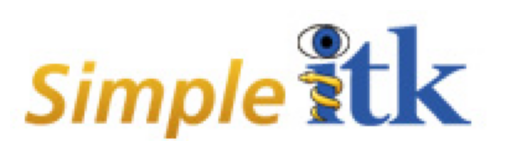

In [19]:
euler2d = sitk.Euler2DTransform()
# Why do we set the center?
euler2d.SetCenter(
    logo.TransformContinuousIndexToPhysicalPoint(np.array(logo.GetSize()) / 2.0)
)

tx = 64
ty = 32
euler2d.SetTranslation((tx, ty))

extreme_points = [
    logo.TransformIndexToPhysicalPoint((0, 0)),
    logo.TransformIndexToPhysicalPoint((logo.GetWidth(), 0)),
    logo.TransformIndexToPhysicalPoint((logo.GetWidth(), logo.GetHeight())),
    logo.TransformIndexToPhysicalPoint((0, logo.GetHeight())),
]
inv_euler2d = euler2d.GetInverse()

extreme_points_transformed = [inv_euler2d.TransformPoint(pnt) for pnt in extreme_points]
min_x = min(extreme_points_transformed)[0]
min_y = min(extreme_points_transformed, key=lambda p: p[1])[1]
max_x = max(extreme_points_transformed)[0]
max_y = max(extreme_points_transformed, key=lambda p: p[1])[1]

# Use the original spacing (arbitrary decision).
output_spacing = logo.GetSpacing()
# Identity cosine matrix (arbitrary decision).
output_direction = [1.0, 0.0, 0.0, 1.0]
# Minimal x,y coordinates are the new origin.
output_origin = [min_x, min_y]
# Compute grid size based on the physical size and spacing.
output_size = [
    int((max_x - min_x) / output_spacing[0]),
    int((max_y - min_y) / output_spacing[1]),
]

resampled_image = sitk.Resample(
    logo,
    output_size,
    euler2d,
    sitk.sitkLinear,
    output_origin,
    output_spacing,
    output_direction,
)
plt.imshow(sitk.GetArrayViewFromImage(resampled_image))
plt.axis("off")
plt.show()

Are you puzzled by the result? Is the output just a copy of the input? Add a rotation to the code above and see what happens (```euler2d.SetAngle(0.79)```).

### Resampling at a set of locations 

In some cases you may be interested in obtaining the intensity values at a set of points (e.g. coloring the vertices of a mesh model segmented from an image).

The code below generates a random point set in the image and resamples the intensity values at these locations. It is written so that it works for all image-dimensions and types (scalar or vector pixels).

In [20]:
img = logo

# Generate random samples inside the image, we will obtain the intensity/color values at these points.
num_samples = 10
physical_points = []
for pnt in zip(
    *[list(np.random.random(num_samples) * (sz - 1)) for sz in img.GetSize()]
):
    physical_points.append(img.TransformContinuousIndexToPhysicalPoint(pnt))

#### Image based approach

SimpleITK images have two methods for obtaining values at arbitrary locations `EvaluateAtPhysicalPoint` and `EvaluateAtContinuousIndex`. As these functions perform interpolation it is important to use an appropriate interpolator. For example, when working with label images we most often do not want to introduce non-label values, which leads us to use the sitkNearestNeighbor interpolator.

Using points outside the image bounds will result in an exception.

In [21]:
resampled_values = [None] * len(physical_points)
for i, pnt in enumerate(physical_points):
    resampled_values[i] = img.EvaluateAtPhysicalPoint(pnt, sitk.sitkLinear)
# Print the interpolated values per point
for i in range(len(physical_points)):
    print(str(physical_points[i]) + ": " + str(resampled_values[i]) + "\n")

(25.153201693545988, 30.62363692357733): (255.0, 253.4842055379071, 255.0)

(90.00393073286057, 17.525715688244475): (254.51598993759387, 254.46662500903602, 250.07088287779015)

(132.12350386746496, 39.28550317637103): (157.73665354418728, 129.52030171585827, 96.57766651336244)

(143.571504461134, 39.48762051376266): (55.40254569055808, 94.53240682890872, 168.0217625991005)

(171.47835608123438, 0.8786882170624692): (255.0, 255.0, 255.0)

(20.68782931602098, 51.10904891479817): (255.0, 255.0, 255.0)

(53.53556258049991, 38.34222186290645): (252.45970319047757, 254.2954372870035, 250.72555884959255)

(147.9564789751711, 33.812225340045714): (254.9564789751711, 255.0, 251.17408409931556)

(98.41439323032183, 12.293876205471797): (255.0, 255.0, 255.0)

(127.55760780871796, 30.209035073979503): (51.976217420519276, 73.08893980978364, 100.09603269874854)



#### Image Resample Filter based approach

We can formulate the same task using the image resampling filter. This approach is slower than the direct approach and will also accept points outside the image bounds, in which case the `default_output_pixel_value` is used (see code below).

In [22]:
# Create an image of size [num_samples,1...1], actual size is dependent on the image dimensionality. The pixel
# type is irrelevant, as the image is just defining the interpolation grid (sitkUInt8 has minimal memory footprint).
interp_grid_img = sitk.Image(
    [num_samples] + [1] * (img.GetDimension() - 1), sitk.sitkUInt8
)

# Define the displacement field transformation, maps the points in the interp_grid_img to the points in the actual
# image.
displacement_img = sitk.Image(
    [num_samples] + [1] * (img.GetDimension() - 1),
    sitk.sitkVectorFloat64,
    img.GetDimension(),
)
for i, pnt in enumerate(physical_points):
    displacement_img[[i] + [0] * (img.GetDimension() - 1)] = np.array(pnt) - np.array(
        interp_grid_img.TransformIndexToPhysicalPoint(
            [i] + [0] * (img.GetDimension() - 1)
        )
    )

# Actually perform the resampling. The only relevant choice here is the interpolator. The default_output_pixel_value
# is set to 0.0, but the resampling should never use it because we expect all points to be inside the image and this
# value is only used if the point is outside the image extent.
interpolator_enum = sitk.sitkLinear
default_output_pixel_value = 0.0
output_pixel_type = (
    sitk.sitkFloat32
    if img.GetNumberOfComponentsPerPixel() == 1
    else sitk.sitkVectorFloat32
)
resampled_values = sitk.Resample(
    img,
    interp_grid_img,
    sitk.DisplacementFieldTransform(displacement_img),
    interpolator_enum,
    default_output_pixel_value,
    output_pixel_type,
)

# Print the interpolated values per point
for i in range(resampled_values.GetWidth()):
    print(
        str(physical_points[i])
        + ": "
        + str(resampled_values[[i] + [0] * (img.GetDimension() - 1)])
        + "\n"
    )

(25.153201693545988, 30.62363692357733): (255.0, 253.4842071533203, 255.0)

(90.00393073286057, 17.525715688244475): (254.5159912109375, 254.4666290283203, 250.0708770751953)

(132.12350386746496, 39.28550317637103): (157.7366485595703, 129.52029418945312, 96.57766723632812)

(143.571504461134, 39.48762051376266): (55.40254592895508, 94.53240966796875, 168.02175903320312)

(171.47835608123438, 0.8786882170624692): (255.0, 255.0, 255.0)

(20.68782931602098, 51.10904891479817): (255.0, 255.0, 255.0)

(53.53556258049991, 38.34222186290645): (252.45970153808594, 254.29544067382812, 250.72555541992188)

(147.9564789751711, 33.812225340045714): (254.95648193359375, 255.0, 251.17408752441406)

(98.41439323032183, 12.293876205471797): (255.0, 255.0, 255.0)

(127.55760780871796, 30.209035073979503): (51.976219177246094, 73.08894348144531, 100.09603118896484)



#### Obtaining an intensity profile along arbitrary segment 

In the next two cells we compute intensity profiles along arbitrary user defined segments using the image based interpolation approach.

Using the GUI below, click on a location and that defines one endpoint. The next point you click on is the second endpoint for that segment. You can define as many segments as you want. Endpoints do not need to be on the same slice.

In [23]:
# Temporarily change the matplotlib back-end to enable mouse interaction
%matplotlib notebook
intensity_profiles_image = sitk.ReadImage(fdata("training_001_ct.mha"))
point_gui = gui.PointDataAquisition(image=intensity_profiles_image);

Fetching training_001_ct.mha


<IPython.core.display.Javascript object>

In [24]:
endpoints = point_gui.get_points()
num_points = len(endpoints)
# We need at least two points to define a single segment and the number of endpoints should be even
if num_points < 2 or num_points % 2 != 0:
    print(
        "At least two points required and the number of points is expected to be even."
    )
else:
    # Change the matplotlib back-end back to inline
    %matplotlib inline
    # Spacing in mm, change it to a value which makes sense for your application
    spacing = np.min(intensity_profiles_image.GetSpacing())
    segment_data = []
    # Iterate over the segments, interpolate values and plot
    # (list is short so not bothering with itertools.pairwise())
    for i in range(0, num_points - 1, 2):
        endpoint0 = np.array(endpoints[i])
        endpoint1 = np.array(endpoints[i + 1])
        segment_size = np.linalg.norm(endpoint1 - endpoint0)
        segment_direction = (endpoint1 - endpoint0) / segment_size
        # Always include second endpoint (it won't necessarily have the same spacing as the other points).
        x_vals = list(np.arange(0, segment_size, spacing)) + [segment_size]
        segment_data.append(
            (
                x_vals,
                [
                    intensity_profiles_image.EvaluateAtPhysicalPoint(
                        endpoint0 + segment_direction * x, sitk.sitkLinear
                    )
                    for x in x_vals
                ],
            )
        )
    plt.xlabel("location on segment (mm)")
    plt.ylabel("intensity")
    for x, y in segment_data:
        plt.plot(x, y)

At least two points required and the number of points is expected to be even.


## <font color="red">Homework:</font> creating a color mesh

You will now use the code for resampling at arbitrary locations to create a colored mesh.

Using the color image of the [visible human](https://en.wikipedia.org/wiki/Visible_Human_Project) head [`img = sitk.ReadImage(fdata('vm_head_rgb.mha'))`]:
1. Implement the [marching cubes algorithm](https://en.wikipedia.org/wiki/Marching_cubes) to obtain the set of triangles corresponding to the iso-surface of structures of interest (skin, white matter,...).
2. Find the color associated with each of the triangle vertices using the code above.
3. Save the data using the ASCII version of the [PLY](https://en.wikipedia.org/wiki/PLY_(file_format)), Polygon File Format (a.k.a. Stanford Triangle Format).
4. Use [meshlab](http://www.meshlab.net/) to view your creation.

### Creating thumbnails - changing image size, spacing and intensity range

As bio-medical images are most often an-isotropic, have a non uniform size (number of pixels), with a high dynamic range of intensities, some caution is required when converting them to an arbitrary desired size with isotropic spacing and the more common low dynamic intensity range.

The code in the following cells illustrates how to take an arbitrary set of images with various sizes, spacings and intensities and resize all of them to a common arbitrary size, isotropic spacing, and low dynamic intensity range. 

In [25]:
file_names = ["cxr.dcm", "photo.dcm", "POPI/meta/00-P.mhd", "training_001_ct.mha"]
images = []
image_file_reader = sitk.ImageFileReader()
for fname in file_names:
    image_file_reader.SetFileName(fdata(fname))
    image_file_reader.ReadImageInformation()
    image_size = list(image_file_reader.GetSize())
    # 2D image posing as a 3D one
    if len(image_size) == 3 and image_size[2] == 1:
        image_size[2] = 0
        image_file_reader.SetExtractSize(image_size)
        images.append(image_file_reader.Execute())
    # 2D image
    elif len(image_size) == 2:
        images.append(image_file_reader.Execute())
    # 3D image grab middle x-z slice
    elif len(image_size) == 3:
        start_index = [0, image_size[1] // 2, 0]
        image_size[1] = 0
        image_file_reader.SetExtractSize(image_size)
        image_file_reader.SetExtractIndex(start_index)
        images.append(image_file_reader.Execute())
    # 4/5D image
    else:
        raise ValueError(f"{image.GetDimension()}D image not supported.")

# Notice that in the display the coronal slices are flipped. As we are
# using matplotlib for display, it is not aware of radiological conventions
# and treats the image as an isotropic array of pixels.
gui.multi_image_display2D(images);

Fetching cxr.dcm
Fetching photo.dcm
Fetching POPI/meta/00-P.mhd
Fetching training_001_ct.mha


GDCMImageIO (0x7fbe58285410): Converting from MONOCHROME1 to MONOCHROME2 may impact the meaning of DICOM attributes related to pixel values.



<IPython.core.display.Javascript object>

## <font color="red">Homework:</font> Why do some of the images displayed above look different from others?

What are the differences between the various images in the `images` list? Write code to query them and check their intensity ranges, sizes and spacings. 

The next cell illustrates how to resize all images to an arbitrary size, using isotropic spacing while maintaining the original aspect ratio.

In [26]:
def resize_and_scale_uint8(image, new_size, outside_pixel_value=0):
    """
    Resize the given image to the given size, with isotropic pixel spacing
    and scale the intensities to [0,255].

    Resizing retains the original aspect ratio, with the original image centered
    in the new image. Padding is added outside the original image extent using the
    provided value.

    :param image: A SimpleITK image.
    :param new_size: List of ints specifying the new image size.
    :param outside_pixel_value: Value in [0,255] used for padding.
    :return: a 2D SimpleITK image with desired size and a pixel type of sitkUInt8
    """
    # Rescale intensities if scalar image with pixel type that isn't sitkUInt8.
    # We rescale first, so that the zero padding makes sense for all original image
    # ranges. If we resized first, a value of zero in a high dynamic range image may
    # be somewhere in the middle of the intensity range and the outer border has a
    # constant but arbitrary value.
    if (
        image.GetNumberOfComponentsPerPixel() == 1
        and image.GetPixelID() != sitk.sitkUInt8
    ):
        final_image = sitk.Cast(sitk.RescaleIntensity(image), sitk.sitkUInt8)
    else:
        final_image = image
    new_spacing = [
        ((osz - 1) * ospc) / (nsz - 1)
        for ospc, osz, nsz in zip(
            final_image.GetSpacing(), final_image.GetSize(), new_size
        )
    ]
    new_spacing = [max(new_spacing)] * final_image.GetDimension()
    center = final_image.TransformContinuousIndexToPhysicalPoint(
        [sz / 2.0 for sz in final_image.GetSize()]
    )
    new_origin = [
        c - c_index * nspc
        for c, c_index, nspc in zip(center, [sz / 2.0 for sz in new_size], new_spacing)
    ]
    final_image = sitk.Resample(
        final_image,
        size=new_size,
        outputOrigin=new_origin,
        outputSpacing=new_spacing,
        defaultPixelValue=outside_pixel_value,
    )
    return final_image


# Select the arbitrary new size
new_size = [128, 128]
resized_images = [resize_and_scale_uint8(image, new_size, 50) for image in images]
gui.multi_image_display2D(resized_images);

<IPython.core.display.Javascript object>